# Thermal Radiation
#### ESE156 2020,  7th notebook, Christian Frankenberg 

In [22]:
# Use our tools (you might need to add packages, see file)
using CUDA
device!(2)
# 0 indexed

include("ese156_tools.jl")
using RadiativeTransfer
using RadiativeTransfer.Architectures
using RadiativeTransfer.CrossSection

# use float32


---
#### Define file and lat/lon

In [15]:
# To change things up, choose lat/lon of your birthplace (or any place you like!)
file_folder = "files"
# Locate articafts, see https://julialang.github.io/Pkg.jl/v1/artifacts/
# file = joinpath(file_folder, "MERRA300.prod.assim.inst6_3d_ana_Nv.20150613.hdf.nc4")

file = "/home/cchristo/proj_christian/rad_transfer_julia/files/MERRA300.prod.assim.inst6_3d_ana_Nv.20150613.hdf.nc4"
timeIndex = 2 # There is 00, 06, 12 and 18 in UTC, i.e. 6 hourly data stacked together

# What latitude do we want?
myLat = 50.642;
myLon = 7.226;

In [16]:
# Read profile (and generate dry/wet VCDs per layer)
profile = read_atmos_profile(file, myLat, myLon, timeIndex);

ds["T"] = T (540 × 361 × 72 × 4)
  Datatype:    Float32
  Dimensions:  XDim × YDim × Height × TIME
  Attributes:
   _FillValue           = 1.0e15
   long_name            = Air temperature
   standard_name        = air_temperature
   units                = K
   scale_factor         = 1.0
   add_offset           = 0.0
   missing_value        = 1.0e15
   fmissing_value       = 1.0e15
   vmin                 = -1.0e30
   vmax                 = 1.0e30
   valid_range          = Float32[-1.0f30, 1.0f30]
   coordinates          = TIME Height YDim XDim
   fullpath             = /EOSGRID/Data Fields/T



---
#### Define HITRAN parameters

In [10]:
# Minimum wavenumber
ν_min  = 200.0
# Maximum wavenumber
ν_xmax = 2000.0

# co2_par = CrossSection.read_hitran(joinpath(file_folder, "hitran_molec_id_2_CO2.par"), mol=2, iso=1, ν_min=ν_min, ν_max=ν_xmax);
# ch4_par = CrossSection.read_hitran(joinpath(file_folder, "hitran_molec_id_6_CH4.par"), mol=6, iso=1, ν_min=ν_min, ν_max=ν_xmax);
# h2o_par = CrossSection.read_hitran(joinpath(file_folder, "hitran_molec_id_1_H2O.par"), mol=1, iso=1, ν_min=ν_min, ν_max=ν_xmax);


co2_par = CrossSection.read_hitran(joinpath(file_folder, "hitran_molec_id_2_CO2.tar"), mol=2, iso=1, ν_min=ν_min, ν_max=ν_xmax);
ch4_par = CrossSection.read_hitran(joinpath(file_folder, "hitran_molec_id_6_CH4.tar"), mol=6, iso=1, ν_min=ν_min, ν_max=ν_xmax);
h2o_par = CrossSection.read_hitran(joinpath(file_folder, "hitran_molec_id_1_H2O.tar"), mol=1, iso=1, ν_min=ν_min, ν_max=ν_xmax);

In [17]:
co2_voigt   = make_hitran_model(co2_par, Voigt(), wing_cutoff=10, CEF=HumlicekWeidemann32SDErrorFunction(), architecture=CrossSection.GPU())
h2o_voigt   = make_hitran_model(h2o_par, Voigt(), wing_cutoff=10, CEF=HumlicekWeidemann32SDErrorFunction(), architecture=CrossSection.GPU())
ch4_voigt   = make_hitran_model(ch4_par, Voigt(), wing_cutoff=10, CEF=HumlicekWeidemann32SDErrorFunction(), architecture=CrossSection.GPU())

hitran_array = [co2_voigt, h2o_voigt, ch4_voigt];

---
#### Define model resolution and compute all cross sections for profile

In [18]:
res = 0.01
ν = 200:res:2000
σ_matrix = compute_profile_crossSections(profile, hitran_array , ν);

Progress: 100%|█████████████████████████████████████████| Time: 0:04:02


In [ ]:
# Reduce dimensions, group layers together to get roughly layers of equal pressure difference:
n_layers = 20
profile_red, σ_matrix_red = reduce_profile(n_layers, profile, σ_matrix);

In [9]:
i = 2; j = 20;
plot(1e4./ν,σ_matrix[:,j,i].+1e-90, yscale=:log10,alpha=0.8, lw=2,label="H₂O")
i = 1;
plot!(1e4./ν,σ_matrix[:,j,i].+1e-90, yscale=:log10, alpha=0.6,lw=2,label="CO₂")
i = 3; 
plot!(1e4./ν,σ_matrix[:,j,i].+1e-90, yscale=:log10, alpha=0.4,lw=2,label="CH₄")
ylims!(1e-35, 1e-15)
xlabel!("Wavelength (μm)")
ylabel!("Cross Section (cm²)")

LoadError: UndefVarError: σ_matrix not defined

In [10]:
# Define concentration profile:
nL = length(profile_red.T)
vmr_co2 = zeros(nL) .+ 400e-6
vmr_ch4 = zeros(nL) .+ 2e-6
vmr_h2o = profile_red.vcd_h2o ./ profile_red.vcd_dry
vmrs = [vmr_co2, vmr_h2o, vmr_ch4 ];
@show nL

LoadError: UndefVarError: profile_red not defined

---
### Define Instrument models:

In [11]:
# Define an Instrument, TCCON specs
FWHM = 0.2  # 0.2cm-1 resolution
Δν = 0.05
satellite = KernelInstrument(gaussian_kernel(FWHM, res), collect(minimum(ν)+2FWHM:Δν:maximum(ν)-2FWHM));

### Planck Curve
Here, we need to define the blackbody radiation as a function of wavelength and Temperature. The equation for total outgoing radiance as a function of wavelength wavelength would be
$$B_\lambda(T)\mathrm{d}\lambda = \frac{2 h c^2}{\lambda^5}\frac{1}{e^{\frac{hc}{\lambda k_BT}}-1}\mathrm{d}\lambda\,$$
with $k_B$ being the Boltzmann constant, $h$ the Planck constant, and c the speed of light. Here, $B_\lambda(T)$ is described in terms of the power (W) emitted per unit area of the body, per unit solid angle (sr) that the radiation is measured over, per unit frequency (in SI unit of meters here, we will need to convert to get to nm or $\mu$m). For the sun, we will want to look at the total radiation emitted at the sun's surface, for which we just have to integrate across all solid angles in one hemisphere, effectively mulitplying by $\pi$.  

Similarly, if we are looking at solar irradiance at the top of the Earth's atmosphere, we need to take the distance between the sun and the earth into account. We do so by computing the ratio of the sphere area with radius of sun-earth distance (1AU) and the surface area of the sun. The radius of the sun is about 695,700km. The distance between the centers of sun and earth is 1 Astronomical Unit (AU), i.e. 149,597,870.7km. The ratio of the distances (sun center to sun surface vs sun center to earth surface) is thus (149597870.7-6300)/695700=215.02. Thus, we have to divide the solar irradiance at the sun's surface by 215.02$^2$ to get to the fluxes at the extended distance. The conversion factor is about 2.1629e-05. 
___________
 First, we need to actually define the Planck function. 

In [12]:
# Some constants and the planck function (as radiance!)
function planck(wav, T)
    h = 6.626e-34
    c = 299792458
    k = 1.38e-23
    c1 = 2h*c^2
    c2 = h*c/(wav*k*T)
    intensity = c1/ ( (wav^5)*(exp(c2) - 1.0) )
    # Convert to W/sr/m^2/µm here directly (it was W/sr/m^2/m)
    return intensity*1.0e-6
end

planck (generic function with 1 method)

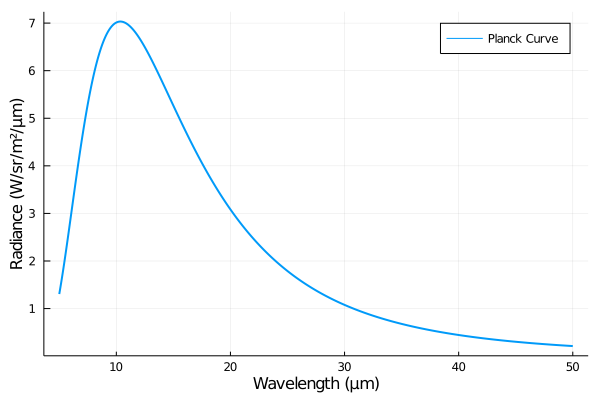

In [13]:
# Define a wavelengths grid (equation demands SI unit of meters).
wl = (1e7*1e-9)./collect(ν[1:100:end]);
plot(wl*1e6, planck.(wl,280), label="Planck Curve",lw=2)
ylabel!("Radiance (W/sr/m²/μm)")
xlabel!("Wavelength (μm)")

---
### Define a simplified Forward model:

In [14]:
function forward_model_thermal(vmrs, σ_matrix, profile, albedo, Tsurf, μ, ν)
    nProfile = length(profile.T)
    nSpec    = size(σ_matrix,1)
    nGas     = length(vmrs)
    
    # wavelength in meter
    wl = (1e7*1e-9)./collect(ν)
    
    # Total sum of τ
    ∑τ       = zeros(nSpec,nProfile)
    
    # Planck Source function
    S        = zeros(nSpec,nProfile)
    
    # Layer boundary up and down fluxes:
    rad_down = zeros(nSpec,nProfile+1)
    rad_up   = zeros(nSpec,nProfile+1)
    
    # Planck Source per layer:
    for i=1:nProfile
        S[:,i] = planck.(wl,profile.T[i])
    end
    
    # sum up total layer τ:
    for i=1:nGas,j=1:nProfile
        ∑τ[:,j] .+= σ_matrix[:,j,i] .* (vmrs[i][j] .* profile.vcd_dry[j])'
    end
    
    # Transmission per layer
    T = exp.(-∑τ/μ)
    
    # Atmosphere from top to bottom:
    for i=1:nProfile
        rad_down[:,i+1] = rad_down[:,i].*T[:,i] .+ (1 .-T[:,i]).*S[:,i]
    end
    
    # Upward flux at surface:
    rad_up[:,end] = (1-albedo)*planck.(wl,Tsurf) .+ rad_down[:,end]*albedo
    
    # Atmosphere from bottom to top
    for i=nProfile:-1:1
        rad_up[:,i] = rad_up[:,i+1].*T[:,i] .+ (1 .-T[:,i]) .* S[:,i]
    end
    
    return T, rad_down, rad_up
end

forward_model_thermal (generic function with 1 method)

In [15]:
@time T, rad_down, rad_up = forward_model_thermal(vmrs,σ_matrix_red, profile_red, 0.05, 280.0, 1.0, ν);

LoadError: UndefVarError: vmrs not defined

In [16]:
plot(1e4./ν, prod(T,dims=2),lw=2)
ylabel!("Total Atmosphere Transmission")
xlabel!("Wavelength (μm)")

LoadError: UndefVarError: T not defined

In [17]:
plot(1e4./ν, rad_up[:,1],lw=2 )
ylabel!("Radiance (W/sr/m²/μm)")
xlabel!("Wavelength (μm)")

LoadError: UndefVarError: rad_up not defined

In [18]:
plot(1e4./ν, rad_down[:,end],lw=2 )
ylabel!("Radiance (W/sr/m²/μm)")
xlabel!("Wavelength (μm)")

LoadError: UndefVarError: rad_down not defined

In [19]:
heatmap(ν, profile_red.p_levels, rad_down', yflip=true)
xlabel!("Wavenumber (cm⁻¹)")
ylabel!("pressure (Pa)")
title!("Downwelling radiation")

LoadError: UndefVarError: rad_down not defined

In [20]:
heatmap(ν, profile_red.p_levels, rad_up', yflip=true)
xlabel!("Wavenumber (cm⁻¹)")
ylabel!("pressure (Pa)")
title!("Downwelling radiation")

LoadError: UndefVarError: rad_up not defined

In [21]:
heatmap(ν, profile_red.p, T', yflip=true)
xlabel!("Wavenumber (cm⁻¹)")
ylabel!("Transmission")

LoadError: UndefVarError: T not defined